In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys;sys.path.append("..")
import socceraction.vaep as vaep
import pandas as pd
import tqdm
import matplotsoccer as mps

In [2]:
games = pd.read_hdf("../data/spadl.h5","games")

actiontypes = pd.read_hdf("../data/spadl.h5", "actiontypes")
bodyparts = pd.read_hdf("../data/spadl.h5", "bodyparts")
results = pd.read_hdf("../data/spadl.h5", "results")

players = pd.read_hdf("../data/spadl.h5", "players")
teams = pd.read_hdf("../data/spadl.h5", "teams")

#players = players.set_index("player_id")
#teams = teams.set_index("team_id")

/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
A = []
for game in tqdm.tqdm(list(games.itertuples())):
    actions = pd.read_hdf("../data/spadl.h5",f"actions/game_{game.game_id}")
    actions = (
        actions.merge(actiontypes)
        .merge(results)
        .merge(bodyparts)
        .merge(players,"left",on="player_id")
        .merge(teams,"left",on="team_id")
        .sort_values(["period_id", "time_seconds", "timestamp"])
        .reset_index(drop=True)
    )
    preds = pd.read_hdf("../data/predictions.h5",f"game_{game.game_id}")
    #preds = preds.reset_index(drop=True)
    values = vaep.value(actions,preds.scores,preds.concedes)
    A.append(pd.concat([actions,preds,values],axis=1))
A = pd.concat(A).sort_values(["game_id","period_id", "time_seconds", "timestamp"]).reset_index(drop=True)

100%|██████████| 45/45 [00:03<00:00, 13.36it/s]


In [4]:
A.columns

Index(['game_id', 'period_id', 'time_seconds', 'timestamp', 'team_id',
       'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'result_id',
       'bodypart_id', 'type_id', 'type_name', 'result_name', 'bodypart_name',
       'first_name', 'fullname', 'soccer_name', 'last_name', 'birthday',
       'nation_id', 'team_abbr', 'team_name', 'team_short', 'scores',
       'concedes', 'offensive_value', 'defensive_value', 'vaep_value'],
      dtype='object')

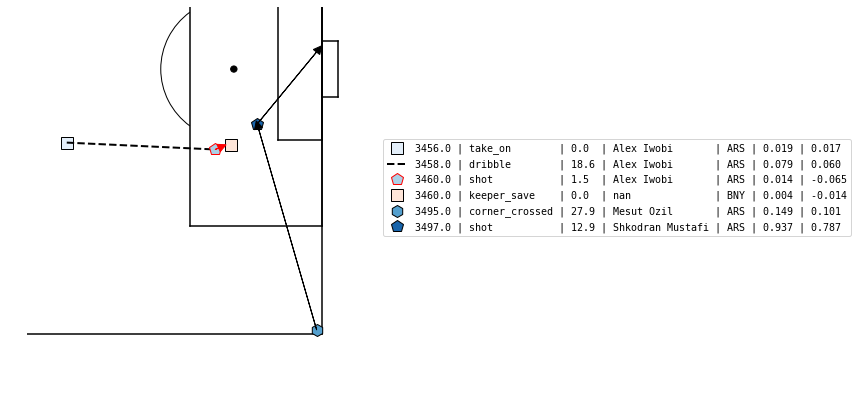

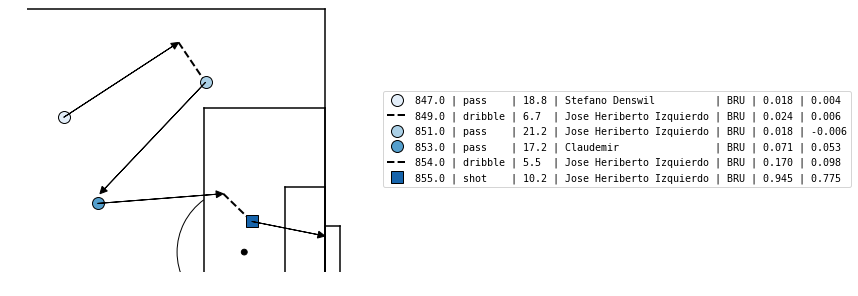

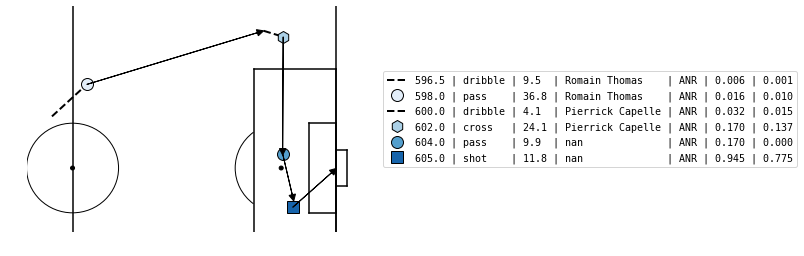

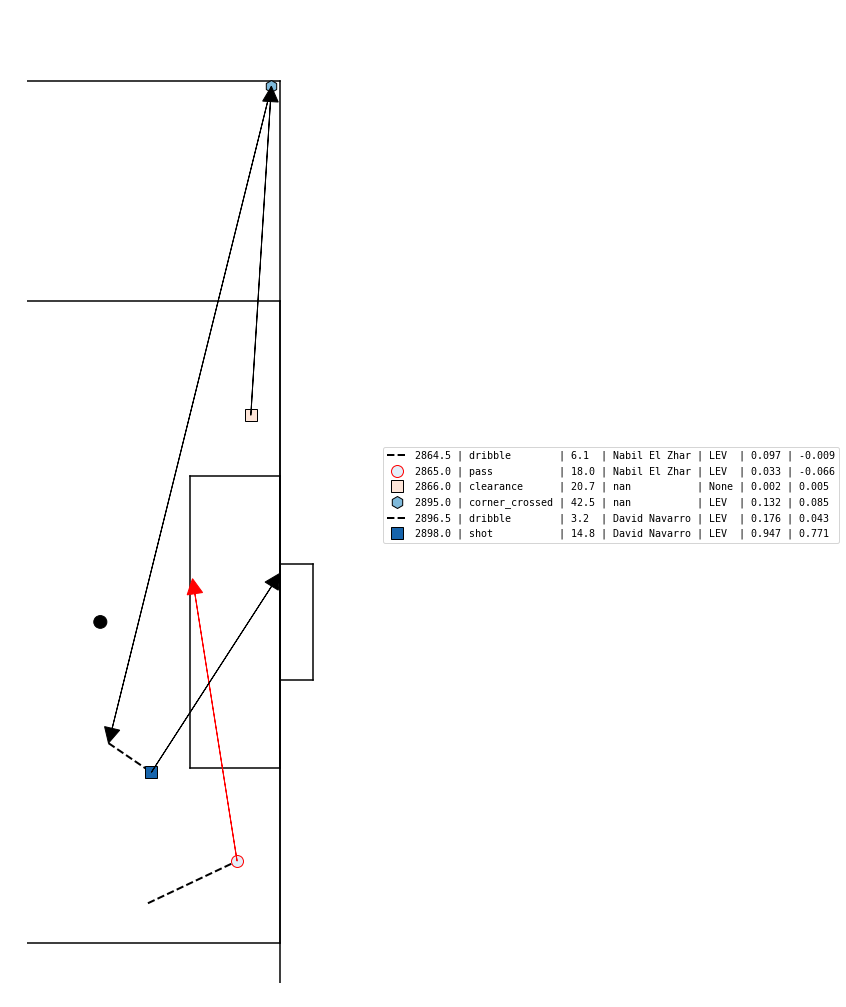

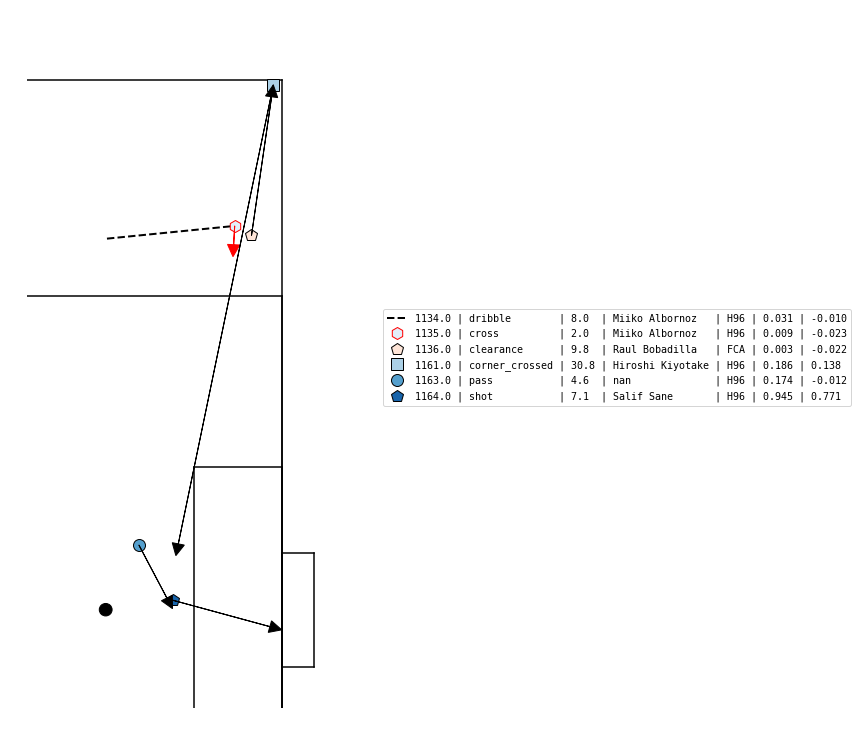

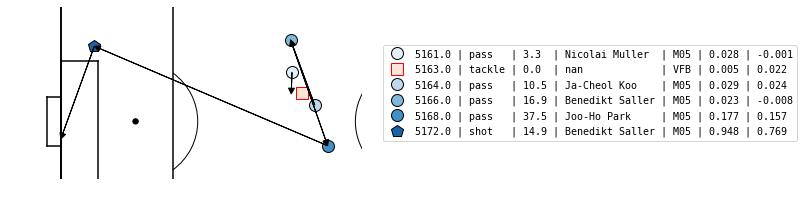

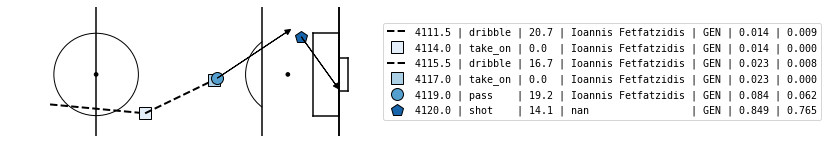

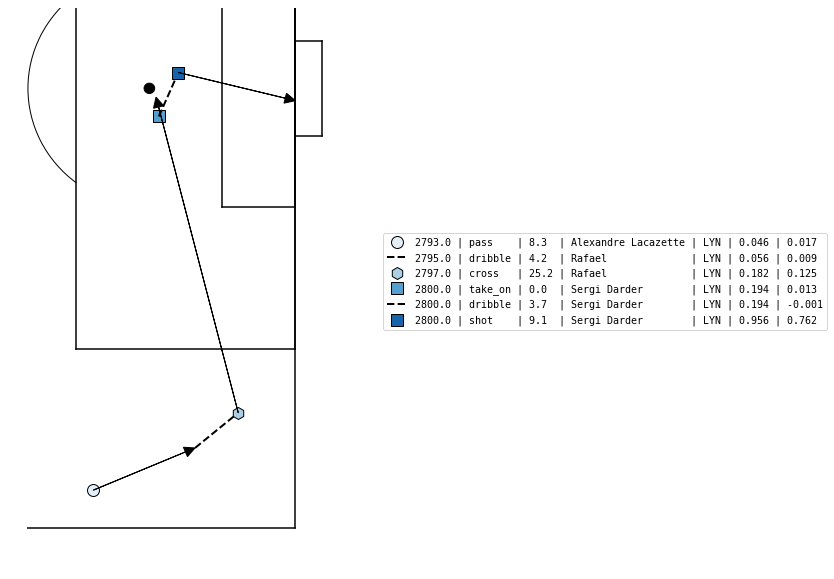

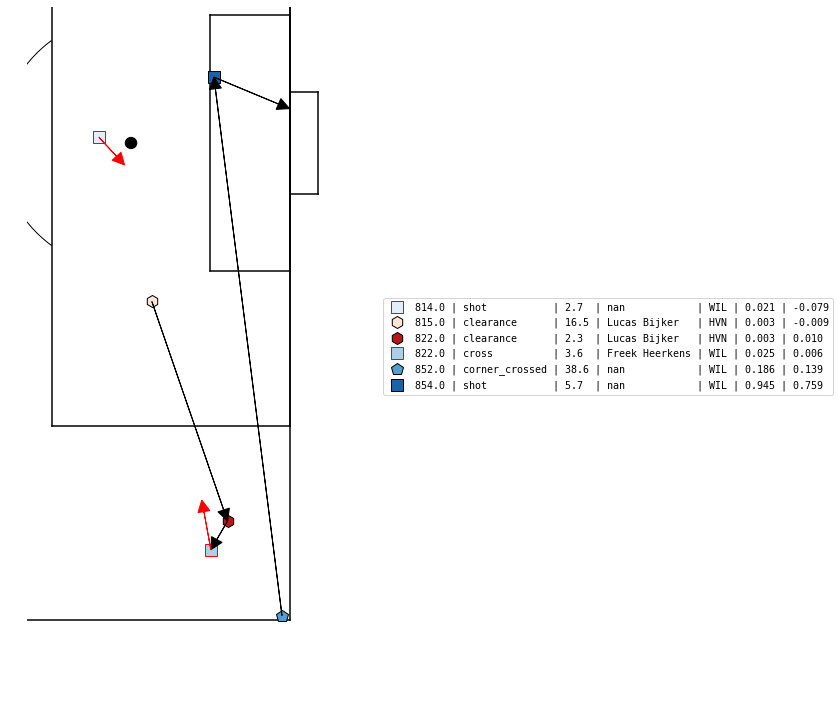

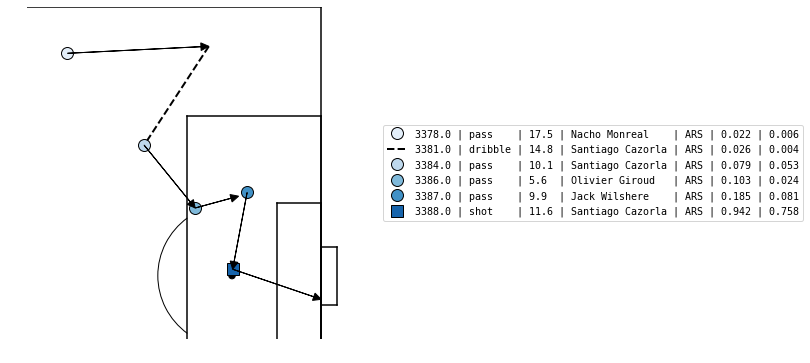

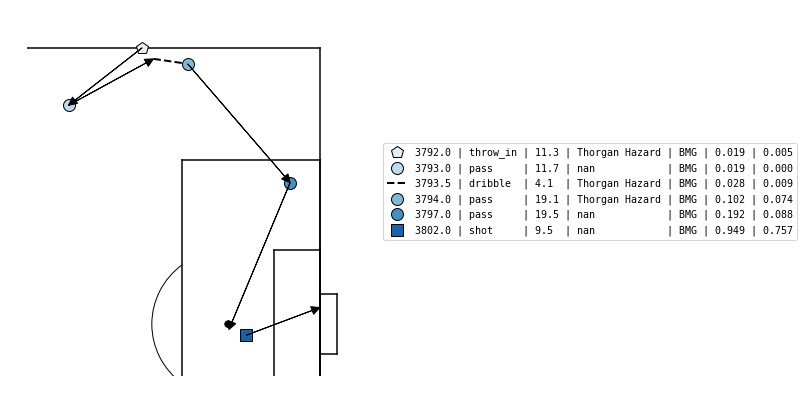

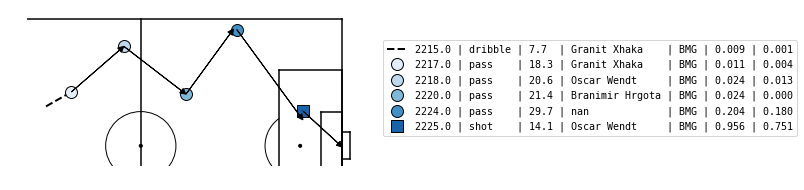

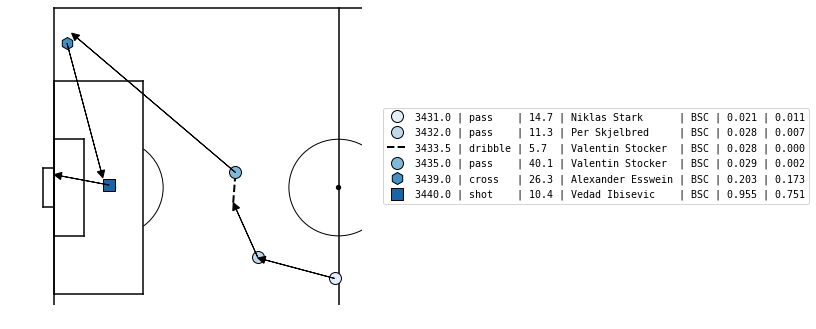

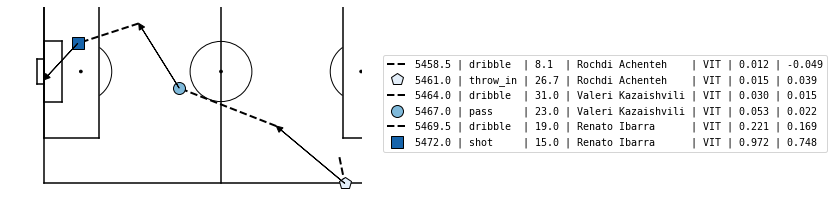

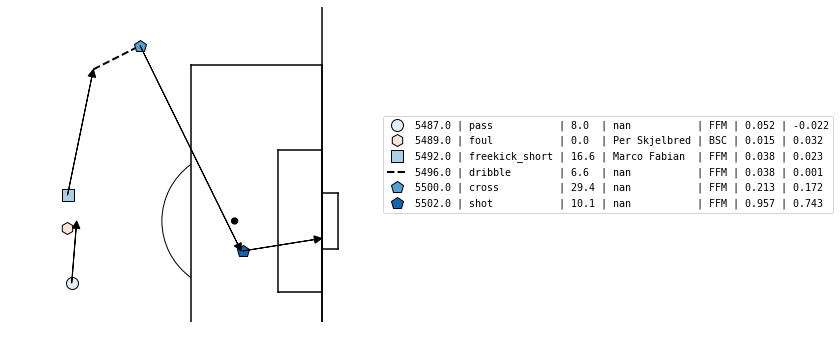

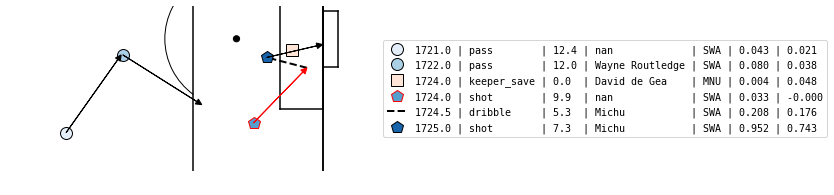

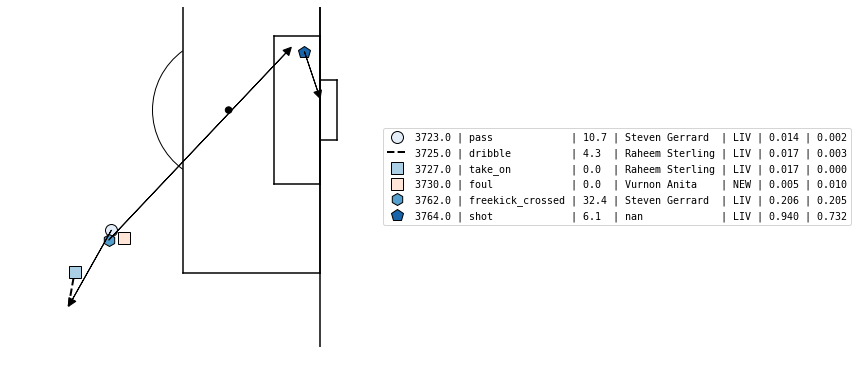

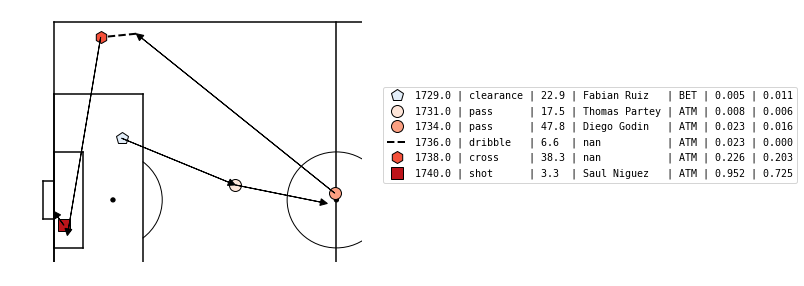

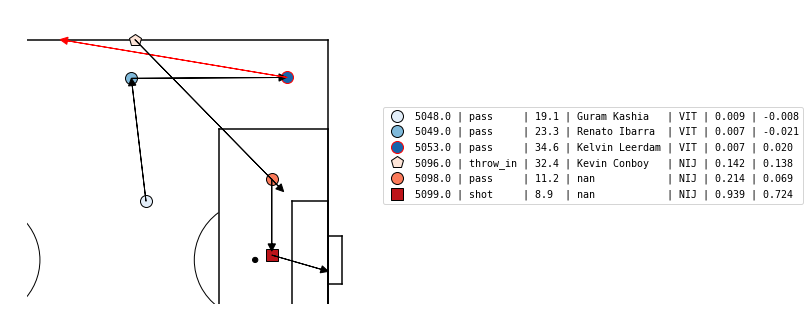

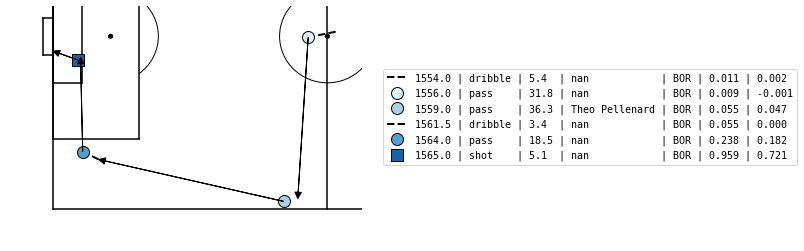

In [8]:
import socceraction.classification.features as fs


i = 58
for j in range(i,i+20):
    i = A.sort_values("offensive_value", ascending=False).index[j]
    a = A[i - 5 : i+1].copy()
    #a = a[1:6]
    mov = fs.movement(a)
    a["mov"] = mov["movement_a0"].apply(lambda x : "%.1f" % x )
    a["scores"] = a.scores.apply(lambda x : "%.3f" % x )
    a["vaep_value"] = a.vaep_value.apply(lambda x : "%.3f" % x )
    labels = a[["time_seconds","type_name","mov","soccer_name","team_abbr","scores","vaep_value"]]
    labeltitle = ["TIME", "PLAYER","ACTION","$P_{scores}$"," VALUE"]
    mps.actions(a[["start_x","start_y","end_x","end_y"]],
                a.type_name,
                team=a.team_name,
                result = a.result_id,
                label=labels,zoom=True)
#A.sort_values("offensive_value", ascending=False).type_name

In [6]:
a[["time_seconds","timestamp","type_name","end_y","start_y","mov","player_id","soccer_name","team_abbr","scores","vaep_value"]]

,time_seconds,timestamp,type_name,end_y,start_y,mov,player_id,soccer_name,team_abbr,scores,vaep_value
49275,3031.0,2016-02-28 21:12:48,pass,44.880,46.920,11.2,54782.0,Javier Pastore,PSG,0.118,0.061
49276,3033.0,2016-02-28 21:12:50,pass,43.452,44.880,4.2,40720.0,Edinson Cavani,PSG,0.118,-0.000
49277,3035.0,2016-02-28 21:12:53,dribble,43.724,39.780,4.1,149519.0,Maxwel Cornet,LYN,0.006,0.063
49278,3035.0,2016-02-28 21:12:53,tackle,43.724,43.724,0.0,149519.0,Maxwel Cornet,LYN,0.006,0.000
49279,3035.0,2016-02-28 21:12:53,bad_touch,39.780,39.780,0.0,44488.0,Mapou Yanga-Mbiwa,LYN,0.003,-0.103
49280,3037.0,2016-02-28 21:12:54,shot,31.280,37.128,14.4,95715.0,Lucas Moura,PSG,0.966,0.807


       time_seconds  type_name
49275        3031.0       pass
49276        3033.0       pass
49277        3035.0    dribble
49279        3035.0  bad_touch
49280        3037.0       shot


49275    False
49276    False
49277     True
49279    False
49280    False
dtype: bool